# Table Transformer를 이용한 테이블 구조 분석

이 노트북은 혈액검사 이미지에서 테이블 구조를 탐지하는 예제입니다.
- 모델: `microsoft/table-transformer-structure-recognition`
- 목적: 테이블의 행, 열, 셀 구조 파악

In [15]:
import sys
import os
from PIL import Image

# img_path = os.path.abspath('notebooks/ocr/assets/images/20241107_2.jpg')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250125.jpeg')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250110.png')
img_path = os.path.abspath('notebooks/ocr/assets/images/20250116_2.png')
print(f"분석할 이미지: {img_path}")

# 이미지 로드
image = Image.open(img_path).convert("RGB")
print(f"이미지 크기: {image.size}")

분석할 이미지: /home/aidan/work/meow-chat/notebooks/ocr/assets/images/20250116_2.png
이미지 크기: (1736, 2008)


In [16]:
# 필요한 라이브러리 설치 및 임포트
import torch
from transformers import AutoImageProcessor, TableTransformerForObjectDetection
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 중인 디바이스: {device}")

# Table Transformer 모델 로드 (구조 인식용)
model_name = "microsoft/table-transformer-structure-recognition"
print(f"모델 로딩 중: {model_name}")

image_processor = AutoImageProcessor.from_pretrained(model_name)
model = TableTransformerForObjectDetection.from_pretrained(model_name).to(device)

print("모델 로딩 완료!")

사용 중인 디바이스: cpu
모델 로딩 중: microsoft/table-transformer-structure-recognition


Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


모델 로딩 완료!


In [17]:
# 이미지 전처리 및 모델 추론
print("이미지 전처리 중...")
inputs = image_processor(images=image, return_tensors="pt").to(device)

print("테이블 구조 분석 중...")
with torch.no_grad():
    outputs = model(**inputs)

# 결과 추출
target_sizes = torch.tensor([image.size[::-1]]).to(device)  # (height, width)
results = image_processor.post_process_object_detection(
    outputs, threshold=0.5, target_sizes=target_sizes
)[0]

print(f"탐지된 객체 수: {len(results['scores'])}")
print(f"신뢰도 점수: {results['scores']}")
print(f"라벨 ID: {results['labels']}")
print(f"바운딩 박스: {results['boxes']}")

# 라벨 매핑 (Table Transformer 구조 인식 모델의 라벨)
id2label = {
    0: "table",
    1: "table column",
    2: "table row", 
    3: "table column header",
    4: "table projected row header",
    5: "table spanning cell"
}

# 탐지된 객체별 정보 출력
for i, (score, label_id, box) in enumerate(zip(results['scores'], results['labels'], results['boxes'])):
    label = id2label.get(label_id.item(), f"unknown_{label_id.item()}")
    print(f"객체 {i+1}: {label} (신뢰도: {score:.3f})")
    print(f"  바운딩 박스: {box.tolist()}")
    print()

이미지 전처리 중...
테이블 구조 분석 중...
탐지된 객체 수: 69
신뢰도 점수: tensor([0.9707, 0.6660, 0.9996, 0.9873, 0.9502, 0.9483, 0.9826, 0.7288, 0.9638,
        0.8084, 0.8945, 0.9455, 0.9586, 0.7612, 0.5597, 0.9822, 0.9949, 0.6760,
        0.8066, 0.6402, 0.9989, 0.8897, 0.7003, 0.9617, 0.7603, 0.7337, 0.7733,
        0.9929, 0.7140, 0.6812, 0.8468, 0.5126, 0.6682, 0.6740, 0.5676, 0.6611,
        0.7604, 0.7016, 0.9978, 0.8465, 0.5093, 0.7746, 0.9857, 0.9949, 0.7777,
        0.7577, 0.6613, 0.9992, 0.6915, 0.7317, 0.6406, 0.9575, 0.7233, 0.9965,
        0.9673, 0.6702, 0.6671, 0.5880, 0.8748, 0.7279, 0.7177, 0.8083, 0.6784,
        0.7816, 0.9467, 0.6857, 0.6957, 1.0000, 0.7334])
라벨 ID: tensor([2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 4, 4, 1, 2, 5, 2, 2, 2, 2, 2, 1, 2, 2, 2,
        2, 2, 2, 2, 4, 2, 2, 2, 5, 2, 5, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2,
        3, 2, 2, 2, 2, 1, 2, 4, 5, 5, 3, 2, 2, 2, 2, 2, 2, 2, 5, 0, 2])
바운딩 박스: tensor([[  75.9183, 1515.4170, 1629.3240, 1559.4885],
        [  75.2930, 1280.2573, 16

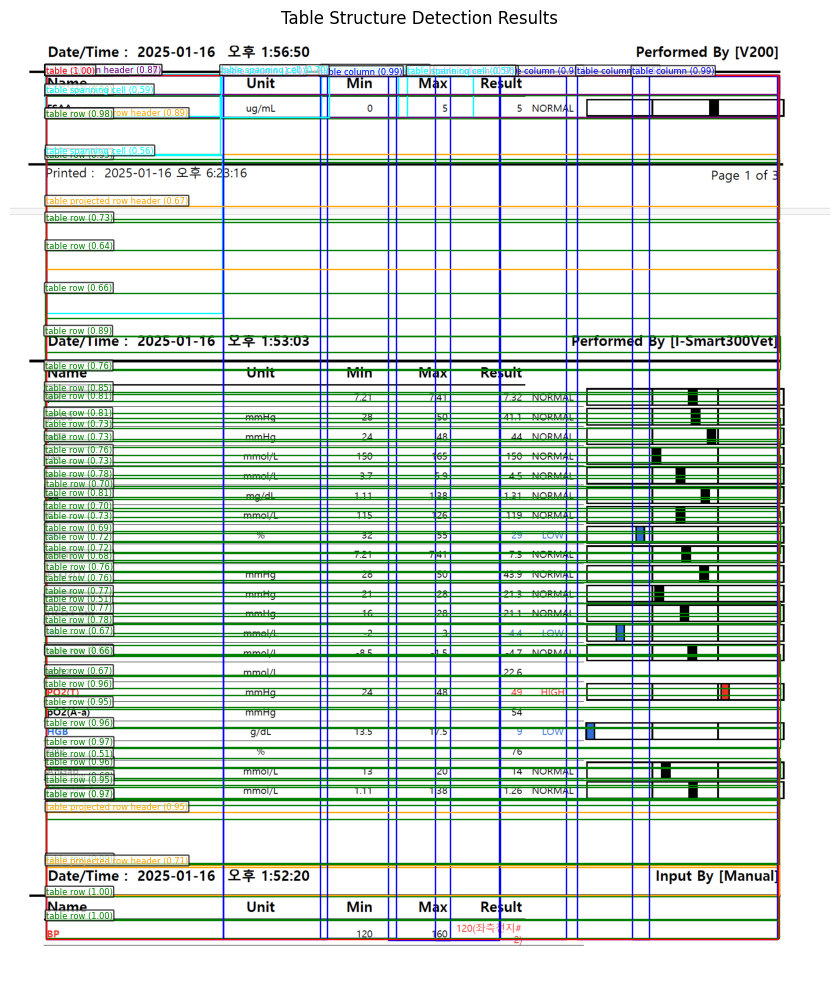

In [18]:
# 결과 시각화
def visualize_table_structure(image, results, id2label, threshold=0.5):
    """테이블 구조 탐지 결과를 시각화합니다."""
    
    # 색상 매핑
    colors = {
        'table': 'red',
        'table column': 'blue', 
        'table row': 'green',
        'table column header': 'purple',
        'table projected row header': 'orange',
        'table spanning cell': 'cyan'
    }
    
    # 그림 설정
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.imshow(image)
    ax.axis('off')
    
    # 바운딩 박스 그리기
    for score, label_id, box in zip(results['scores'], results['labels'], results['boxes']):
        if score > threshold:
            label = id2label.get(label_id.item(), f"unknown_{label_id.item()}")
            color = colors.get(label, 'yellow')
            
            # 바운딩 박스 좌표 (x1, y1, x2, y2)
            x1, y1, x2, y2 = box.tolist()
            width = x2 - x1
            height = y2 - y1
            
            # 바운딩 박스 그리기
            rect = patches.Rectangle(
                (x1, y1), width, height,
                linewidth=1, edgecolor=color, facecolor='none'
            )
            ax.add_patch(rect)
            
            # 라벨 텍스트 추가
            ax.text(
                x1, y1 - 5, f'{label} ({score:.2f})',
                fontsize=6, color=color, weight='normal',
                bbox=dict(boxstyle="round,pad=0.1", facecolor='white', alpha=0.7)
            )
    
    plt.title('Table Structure Detection Results', fontsize=12, fontweight='normal')
    plt.tight_layout()
    plt.show()

# 결과 시각화 실행
visualize_table_structure(image, results, id2label)

In [19]:
# 구조 분석 결과 상세 분석
def analyze_table_structure(results, id2label, threshold=0.5):
    """테이블 구조 분석 결과를 상세히 분석합니다."""
    
    structure_counts = {}
    high_confidence_objects = []
    
    for score, label_id, box in zip(results['scores'], results['labels'], results['boxes']):
        if score > threshold:
            label = id2label.get(label_id.item(), f"unknown_{label_id.item()}")
            
            # 카운트 업데이트
            structure_counts[label] = structure_counts.get(label, 0) + 1
            
            # 고신뢰도 객체 저장
            high_confidence_objects.append({
                'label': label,
                'confidence': score.item(),
                'box': box.tolist()
            })
    
    return structure_counts, high_confidence_objects

# 분석 실행
structure_counts, high_confidence_objects = analyze_table_structure(results, id2label)

print("=== 테이블 구조 분석 결과 ===")
print(f"총 탐지된 구조 요소: {len(high_confidence_objects)}개")
print("\n구조 요소별 개수:")
for structure, count in structure_counts.items():
    print(f"  {structure}: {count}개")

print(f"\n행(row) 개수: {structure_counts.get('table row', 0)}개")
print(f"열(column) 개수: {structure_counts.get('table column', 0)}개")
print(f"헤더 개수: {structure_counts.get('table column header', 0) + structure_counts.get('table projected row header', 0)}개")

# 가장 높은 신뢰도의 객체들 출력
print(f"\n=== 높은 신뢰도 객체 Top 5 ===")
sorted_objects = sorted(high_confidence_objects, key=lambda x: x['confidence'], reverse=True)
for i, obj in enumerate(sorted_objects[:5]):
    print(f"{i+1}. {obj['label']}: {obj['confidence']:.3f}")
    x1, y1, x2, y2 = obj['box']
    print(f"   위치: ({x1:.1f}, {y1:.1f}) - ({x2:.1f}, {y2:.1f})")
    print(f"   크기: {x2-x1:.1f} x {y2-y1:.1f}")
    print()

=== 테이블 구조 분석 결과 ===
총 탐지된 구조 요소: 69개

구조 요소별 개수:
  table row: 48개
  table column: 8개
  table projected row header: 4개
  table spanning cell: 6개
  table column header: 2개
  table: 1개

행(row) 개수: 48개
열(column) 개수: 8개
헤더 개수: 6개

=== 높은 신뢰도 객체 Top 5 ===
1. table: 1.000
   위치: (75.7, 91.9) - (1627.7, 1922.1)
   크기: 1552.0 x 1830.2

2. table row: 1.000
   위치: (75.7, 1832.6) - (1629.2, 1881.2)
   크기: 1553.5 x 48.6

3. table row: 0.999
   위치: (76.0, 1882.9) - (1629.8, 1921.0)
   크기: 1553.8 x 38.1

4. table column: 0.999
   위치: (75.4, 92.6) - (451.6, 1921.7)
   크기: 376.2 x 1829.1

5. table row: 0.998
   위치: (75.1, 92.3) - (1629.0, 134.3)
   크기: 1553.8 x 42.0



In [20]:
# 테이블 구조 매트릭스 생성
def create_table_matrix(results, id2label, image_size, threshold=0.5):
    """테이블의 행과 열 정보를 기반으로 구조 매트릭스를 생성합니다."""
    
    rows = []
    columns = []
    
    for score, label_id, box in zip(results['scores'], results['labels'], results['boxes']):
        if score > threshold:
            label = id2label.get(label_id.item(), f"unknown_{label_id.item()}")
            x1, y1, x2, y2 = box.tolist()
            
            if label == 'table row':
                rows.append({'y1': y1, 'y2': y2, 'center_y': (y1 + y2) / 2})
            elif label == 'table column':
                columns.append({'x1': x1, 'x2': x2, 'center_x': (x1 + x2) / 2})
    
    # 행과 열을 위치순으로 정렬
    rows.sort(key=lambda x: x['center_y'])
    columns.sort(key=lambda x: x['center_x'])
    
    print(f"정렬된 행 개수: {len(rows)}")
    print(f"정렬된 열 개수: {len(columns)}")
    
    return rows, columns

# 매트릭스 생성
rows, columns = create_table_matrix(results, id2label, image.size)

print("\n=== 테이블 구조 매트릭스 정보 ===")
print(f"예상 테이블 크기: {len(rows)} 행 × {len(columns)} 열")

# 행 정보 출력 (처음 10개만)
print(f"\n처음 10개 행의 Y 좌표:")
for i, row in enumerate(rows[:10]):
    print(f"  행 {i+1}: Y {row['y1']:.1f} ~ {row['y2']:.1f} (중심: {row['center_y']:.1f})")

# 열 정보 출력
print(f"\n모든 열의 X 좌표:")
for i, col in enumerate(columns):
    print(f"  열 {i+1}: X {col['x1']:.1f} ~ {col['x2']:.1f} (중심: {col['center_x']:.1f})")

print(f"\n이 혈액검사 결과표는 {len(rows)}개의 검사 항목과 {len(columns)}개의 데이터 열로 구성되어 있습니다.")
print("각 검사 항목마다 참고값, 결과값, 단위 등의 정보가 포함되어 있는 것으로 보입니다.")

정렬된 행 개수: 48
정렬된 열 개수: 8

=== 테이블 구조 매트릭스 정보 ===
예상 테이블 크기: 48 행 × 8 열

처음 10개 행의 Y 좌표:
  행 1: Y 92.3 ~ 134.3 (중심: 113.3)
  행 2: Y 134.0 ~ 182.7 (중심: 158.3)
  행 3: Y 183.6 ~ 275.8 (중심: 229.7)
  행 4: Y 270.2 ~ 397.5 (중심: 333.9)
  행 5: Y 403.8 ~ 606.4 (중심: 505.1)
  행 6: Y 463.1 ~ 645.3 (중심: 554.2)
  행 7: Y 553.3 ~ 679.6 (중심: 616.4)
  행 8: Y 644.2 ~ 715.4 (중심: 679.8)
  행 9: Y 717.8 ~ 767.8 (중심: 742.8)
  행 10: Y 763.5 ~ 807.8 (중심: 785.7)

모든 열의 X 좌표:
  열 1: X 75.4 ~ 451.6 (중심: 263.5)
  열 2: X 451.2 ~ 671.7 (중심: 561.5)
  열 3: X 656.2 ~ 816.9 (중심: 736.6)
  열 4: X 800.1 ~ 930.8 (중심: 865.4)
  열 5: X 899.6 ~ 1036.2 (중심: 967.9)
  열 6: X 1038.7 ~ 1176.6 (중심: 1107.6)
  열 7: X 1199.9 ~ 1353.7 (중심: 1276.8)
  열 8: X 1317.3 ~ 1625.4 (중심: 1471.4)

이 혈액검사 결과표는 48개의 검사 항목과 8개의 데이터 열로 구성되어 있습니다.
각 검사 항목마다 참고값, 결과값, 단위 등의 정보가 포함되어 있는 것으로 보입니다.
